## BUSINESS PROBLEM

#### Customer churn is the loss of clients or customers for companies.
#### The purpose of this study is to build and customize prediction models to classify whether a customer is going to churn or not. 

#### Variables are as follows:

+ Surname : Customers' surname
+ CreditScore : Credit score achieved
+ Geography : Germany, France, Spain
+ Gender : Female, Male
+ Age : Customers' age
+ Tenure : Number of years
+ Balance : Money
+ NumOfProducts : Number of bank products used
+ HasCrCard : The state of having credit card or not
+ IsActiveMember : The state of active membership
+ EstimatedSalary :
+ Exited : Churn or not

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 


## PYSPARK INSTALLATION

In [68]:
import findspark
findspark.init("C:\Spark")

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession.builder \
    .master("local") \
    .appName("pyspark_entry") \
    .getOrCreate()
    
sc = spark.sparkContext
sc

<SparkContext master=local appName=pyspark_entry>

## DATA UNDERSTANDING & EXPLATORY DATA ANLAYSIS

In [69]:
sdf = spark.read.csv("churn.csv", header = True, inferSchema = True)

In [70]:
sdf.show(10, truncate = True)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

In [71]:
import pandas as pd
pd.DataFrame(sdf.take(5), columns=sdf.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [72]:
sdf.describe('Age', 'Tenure', 'Balance', 'NumOfProducts').show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               Age|            Tenure|          Balance|     NumOfProducts|
+-------+------------------+------------------+-----------------+------------------+
|  count|             10000|             10000|            10000|             10000|
|   mean|           38.9218|            5.0128|76485.88928799961|            1.5302|
| stddev|10.487806451704587|2.8921743770496837|62397.40520238599|0.5816543579989917|
|    min|                18|                 0|              0.0|                 1|
|    max|                92|                10|        250898.09|                 4|
+-------+------------------+------------------+-----------------+------------------+



In [73]:
sdf.groupby("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



In [74]:
sdf.createOrReplaceTempView("tbl_df")
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |   tbl_df|       true|
+--------+---------+-----------+



In [75]:
spark.sql("select Age, Balance, Tenure, NumOfProducts from tbl_df").show(5)

+---+---------+------+-------------+
|Age|  Balance|Tenure|NumOfProducts|
+---+---------+------+-------------+
| 42|      0.0|     2|            1|
| 41| 83807.86|     1|            1|
| 42| 159660.8|     8|            3|
| 39|      0.0|     1|            2|
| 43|125510.82|     2|            1|
+---+---------+------+-------------+
only showing top 5 rows



In [76]:
spark.sql("select Exited, mean(Age), sum(Balance) from tbl_df where tenure > 3 group by Exited").show()

+------+-----------------+--------------------+
|Exited|        mean(Age)|        sum(Balance)|
+------+-----------------+--------------------+
|     1|44.55941358024691|1.1946083042999984E8|
|     0|37.34622042700519| 3.722082487300002E8|
+------+-----------------+--------------------+



In [77]:
sdf_pd= sdf.toPandas()

In [78]:
sdf_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int32  
 1   CustomerId       10000 non-null  int32  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int32  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int32  
 7   Tenure           10000 non-null  int32  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int32  
 10  HasCrCard        10000 non-null  int32  
 11  IsActiveMember   10000 non-null  int32  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int32  
dtypes: float64(2), int32(9), object(3)
memory usage: 742.3+ KB


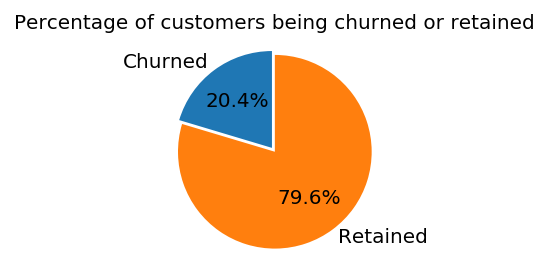

In [79]:
# Displaying the percentage of customers being churn or retain
labels = 'Churned', 'Retained'
sizes = [sdf_pd.Exited[sdf_pd['Exited'] == 1].count(), sdf_pd.Exited[sdf_pd['Exited'] == 0].count()]
explode = (0, 0.05)
fig1, ax1 = plt.subplots(figsize = (4, 2))
ax1.pie(sizes, explode=explode, labels = labels, autopct='%1.1f%%',
        shadow = False, startangle = 90)
ax1.axis('equal')
plt.title("Percentage of customers being churned or retained", size = 10)
plt.show()

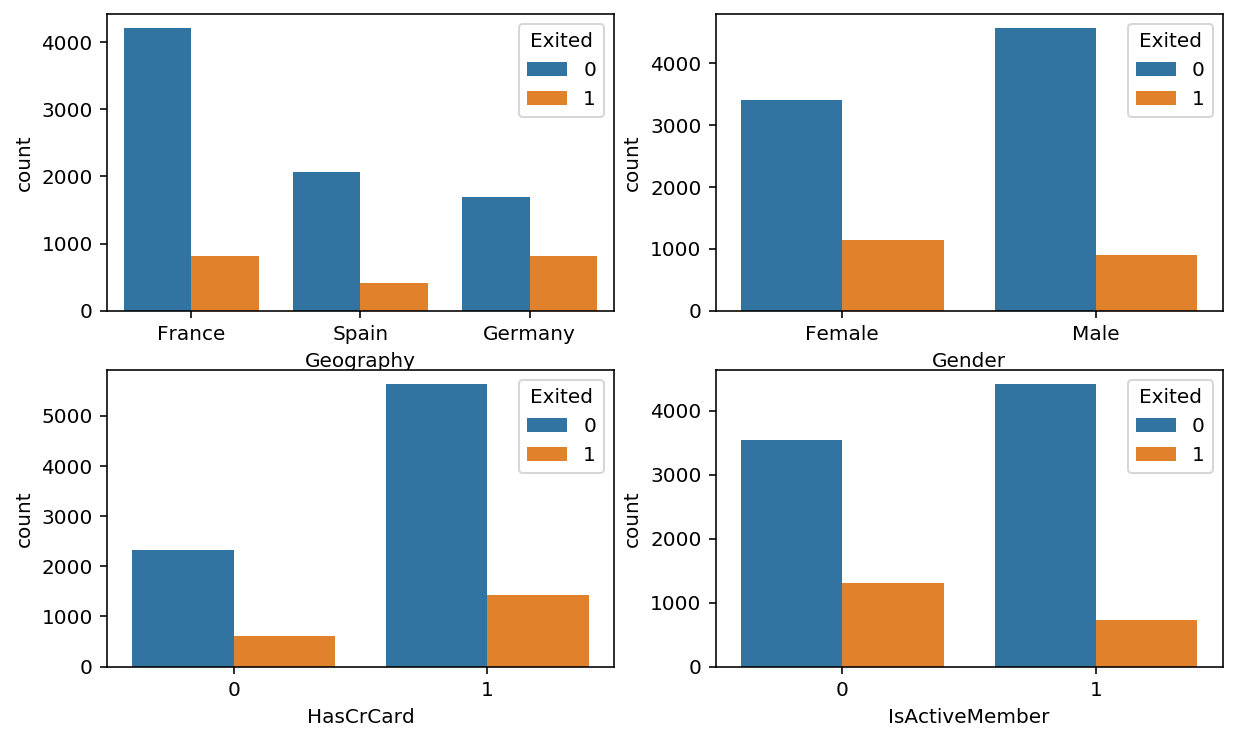

In [80]:
# Displaying the churn status of customers by categorical variables  
fig, axarr = plt.subplots(2, 2, figsize=(10, 6))
sns.countplot(x='Geography', hue = 'Exited',data = sdf_pd, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = sdf_pd, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = sdf_pd, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = sdf_pd, ax=axarr[1][1]);

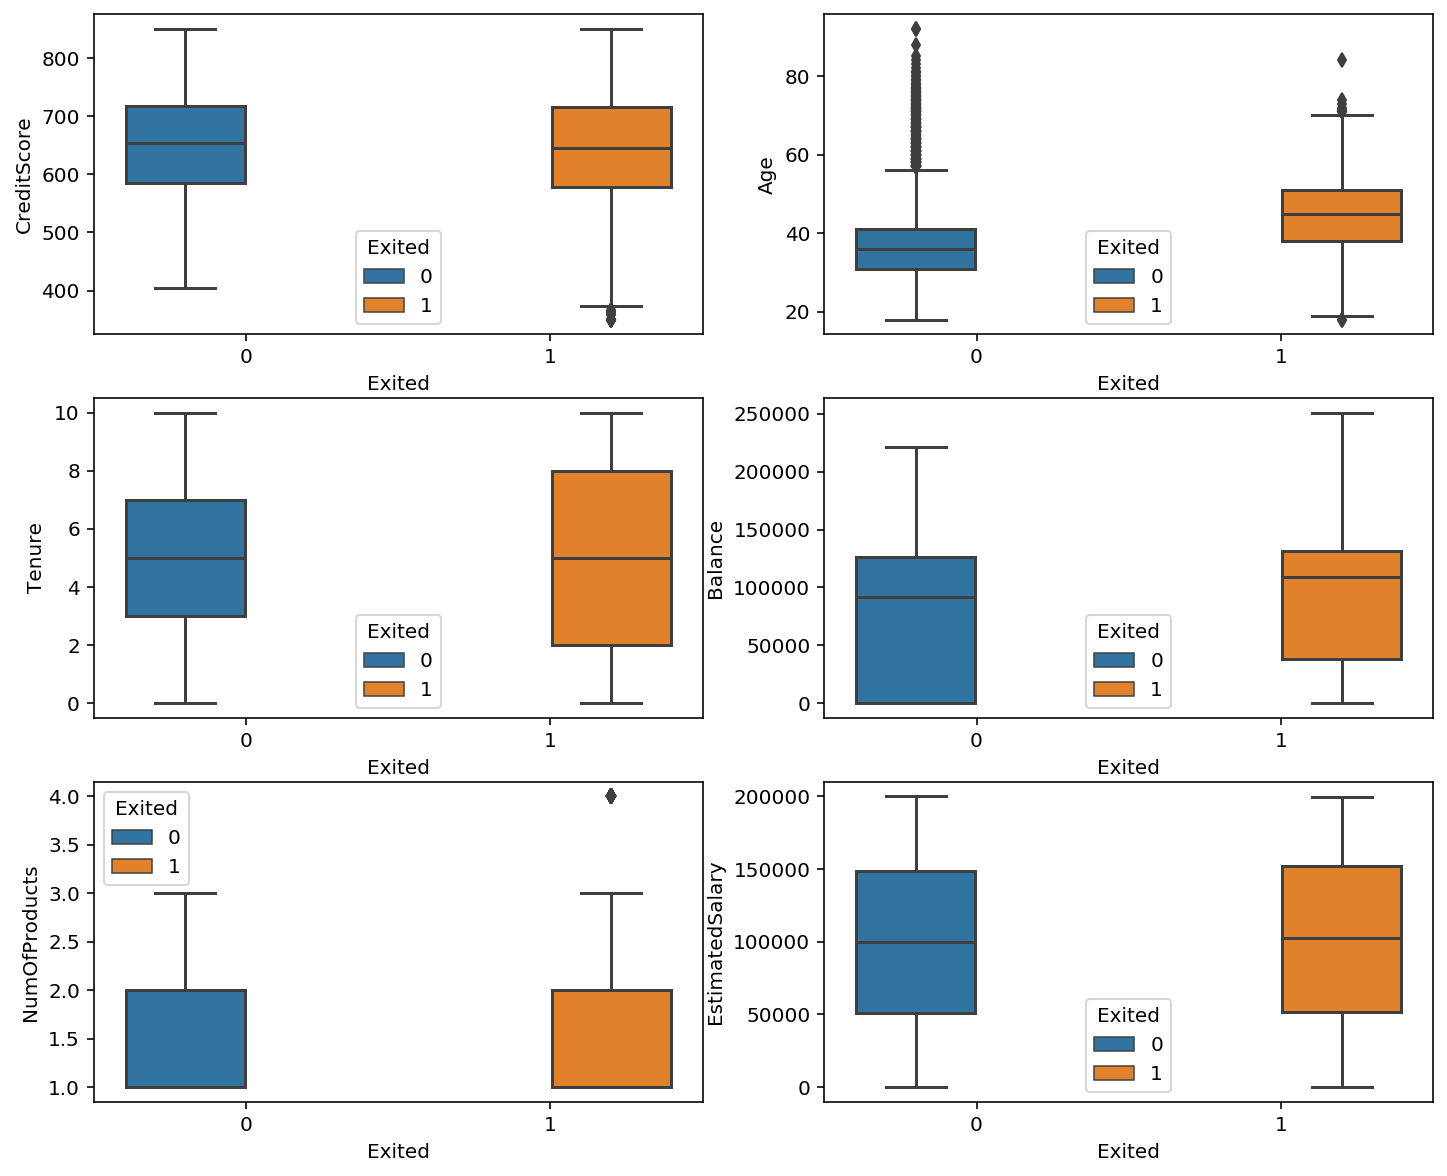

In [81]:
fig, axarr = plt.subplots(3, 2, figsize=(12, 10))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = sdf_pd, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = sdf_pd , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = sdf_pd, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = sdf_pd, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = sdf_pd, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = sdf_pd, ax=axarr[2][1]);

## FETAURE ENGINEERING

In [82]:
Age_Cat = pd.Series(["18-25", "26-33", "34-41", "42-49", "50-57", "58 and older"], dtype = "category")
sdf_pd["Age_Cat"] = Age_Cat
sdf_pd.loc[sdf_pd["Age"] <= 25, "Age_Cat"] = Age_Cat[0]
sdf_pd.loc[(sdf_pd["Age"] > 25) & (sdf_pd["Age"] <= 33), "Age_Cat"] = Age_Cat[1]
sdf_pd.loc[(sdf_pd["Age"] > 33) & (sdf_pd["Age"] <= 41), "Age_Cat"] = Age_Cat[2]
sdf_pd.loc[(sdf_pd["Age"] > 41) & (sdf_pd["Age"] <= 49), "Age_Cat"] = Age_Cat[3]
sdf_pd.loc[(sdf_pd["Age"] > 49) & (sdf_pd["Age"] <= 57), "Age_Cat"] = Age_Cat[4]
sdf_pd.loc[sdf_pd["Age"] > 57 ,"Age_Cat"] = Age_Cat[5]

sdf_pd['new_tenure'] = sdf_pd.Tenure / sdf_pd.Age

sdf_pd['balance_salary_ratio'] = sdf_pd.Balance/sdf_pd.EstimatedSalary

sdf_pd.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_Cat,new_tenure,balance_salary_ratio
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,42-49,0.047619,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,34-41,0.024390,0.744677
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,42-49,0.190476,1.401375
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,34-41,0.025641,0.000000
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,42-49,0.046512,1.587055


In [83]:
cont_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'new_tenure', 'balance_salary_ratio']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography','Gender', 'Age_Cat']
sdf_pd = sdf_pd[['Exited'] + cont_vars + cat_vars]
sdf_pd.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,new_tenure,balance_salary_ratio,HasCrCard,IsActiveMember,Geography,Gender,Age_Cat
0,1,619,42,2,0.00,1,101348.88,0.047619,0.000000,1,1,France,Female,42-49
1,0,608,41,1,83807.86,1,112542.58,0.024390,0.744677,0,1,Spain,Female,34-41
2,1,502,42,8,159660.80,3,113931.57,0.190476,1.401375,1,0,France,Female,42-49
3,0,699,39,1,0.00,2,93826.63,0.025641,0.000000,0,0,France,Female,34-41
4,0,850,43,2,125510.82,1,79084.10,0.046512,1.587055,1,1,Spain,Female,42-49


In [84]:
# Gender variable was decoded as dummy by lable encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
sdf_pd['Gender'] = le.fit_transform(sdf_pd['Gender'])

# Geography and Age_Cat Variables were recoded as dummy
sdf_pd = pd.get_dummies(sdf_pd, columns =["Geography","Age_Cat"], drop_first = True)

sdf_pd.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,new_tenure,balance_salary_ratio,HasCrCard,IsActiveMember,Gender,Geography_Germany,Geography_Spain,Age_Cat_26-33,Age_Cat_34-41,Age_Cat_42-49,Age_Cat_50-57,Age_Cat_58 and older
0,1,619,42,2,0.00,1,101348.88,0.047619,0.000000,1,1,0,0,0,0,0,1,0,0
1,0,608,41,1,83807.86,1,112542.58,0.024390,0.744677,0,1,0,0,1,0,1,0,0,0
2,1,502,42,8,159660.80,3,113931.57,0.190476,1.401375,1,0,0,0,0,0,0,1,0,0
3,0,699,39,1,0.00,2,93826.63,0.025641,0.000000,0,0,0,0,0,0,1,0,0,0
4,0,850,43,2,125510.82,1,79084.10,0.046512,1.587055,1,1,0,0,1,0,0,1,0,0


In [85]:
categorical_df = sdf_pd[['HasCrCard', 'IsActiveMember', 'Gender', 'Geography_Germany', 
                     'Geography_Spain', 'Age_Cat_26-33', 'Age_Cat_34-41', 'Age_Cat_42-49', 
                     'Age_Cat_50-57', 'Age_Cat_58 and older']]

continues_df = sdf_pd[['Age','Tenure','CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'new_tenure', 'balance_salary_ratio']]

In [86]:
cols = continues_df.columns
index = continues_df.index

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(continues_df)
continues_df = pd.DataFrame(scaled, columns = cols, index = index)

continues_df.head()

,Age,Tenure,CreditScore,Balance,NumOfProducts,EstimatedSalary,new_tenure,balance_salary_ratio
0,0.324324,0.2,0.538,0.000000,0.000000,0.506735,0.085714,0.000000
1,0.310811,0.1,0.516,0.334031,0.000000,0.562709,0.043902,0.000070
2,0.324324,0.8,0.304,0.636357,0.666667,0.569654,0.342857,0.000132
3,0.283784,0.1,0.698,0.000000,0.333333,0.469120,0.046154,0.000000
4,0.337838,0.2,1.000,0.500246,0.000000,0.395400,0.083721,0.000150


In [87]:
final_df = pd.concat([continues_df,categorical_df, sdf_pd['Exited']], axis = 1)
final_df.head()

,Age,Tenure,CreditScore,Balance,NumOfProducts,EstimatedSalary,new_tenure,balance_salary_ratio,HasCrCard,IsActiveMember,Gender,Geography_Germany,Geography_Spain,Age_Cat_26-33,Age_Cat_34-41,Age_Cat_42-49,Age_Cat_50-57,Age_Cat_58 and older,Exited
0,0.324324,0.2,0.538,0.000000,0.000000,0.506735,0.085714,0.000000,1,1,0,0,0,0,0,1,0,0,1
1,0.310811,0.1,0.516,0.334031,0.000000,0.562709,0.043902,0.000070,0,1,0,0,1,0,1,0,0,0,0
2,0.324324,0.8,0.304,0.636357,0.666667,0.569654,0.342857,0.000132,1,0,0,0,0,0,0,1,0,0,1
3,0.283784,0.1,0.698,0.000000,0.333333,0.469120,0.046154,0.000000,0,0,0,0,0,0,1,0,0,0,0
4,0.337838,0.2,1.000,0.500246,0.000000,0.395400,0.083721,0.000150,1,1,0,0,1,0,0,1,0,0,0


In [88]:
spark_df = spark.createDataFrame(final_df)
type(spark_df)

pyspark.sql.dataframe.DataFrame

In [89]:
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol = "Exited", outputCol = "label")
mod = stringIndexer.fit(spark_df)
indexed = mod.transform(spark_df)

spark_df = indexed.withColumn("label", indexed["label"].cast("integer"))

In [90]:
from pyspark.ml.feature import VectorAssembler
cols = ['Age', 'Tenure','CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'new_tenure', 'balance_salary_ratio','HasCrCard', 
        'IsActiveMember','Gender', 'Geography_Germany', 'Geography_Spain','Age_Cat_26-33', 
        'Age_Cat_34-41','Age_Cat_42-49', 'Age_Cat_50-57', 'Age_Cat_58 and older']
va = VectorAssembler(inputCols = cols, outputCol = "features")
va_df = va.transform(spark_df)

In [91]:
model_df = va_df.select(["features","label"])
model_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(18,[0,1,2,5,6,8,...|    1|
|(18,[0,1,2,3,5,6,...|    0|
|(18,[0,1,2,3,4,5,...|    1|
|(18,[0,1,2,4,5,6,...|    0|
|[0.33783783783783...|    0|
|[0.35135135135135...|    1|
|(18,[0,1,2,4,5,6,...|    0|
|[0.14864864864864...|    1|
|[0.35135135135135...|    0|
|[0.12162162162162...|    0|
|(18,[0,1,2,3,4,5,...|    0|
|(18,[0,1,2,4,5,6,...|    0|
|(18,[0,1,2,4,5,6,...|    0|
|(18,[0,1,2,4,5,6]...|    0|
|(18,[0,1,2,4,5,6,...|    0|
|[0.36486486486486...|    0|
|[0.54054054054054...|    1|
|(18,[0,1,2,4,5,6,...|    0|
|(18,[0,1,2,5,6,10...|    0|
|(18,[0,1,2,4,5,6,...|    0|
+--------------------+-----+
only showing top 20 rows



## MODEL DEVELOPMENT

In [92]:
splits = model_df.randomSplit([0.70, 0.30])
train_df = splits[0]
test_df = splits[1]
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 7010
Test Dataset Count: 2990


### LOGISTIC REGRESSION

In [93]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr_model = lr.fit(train_df)

y_pred = lr_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count()/ac.count()

0.8237458193979933

In [94]:
predictions = lr_model.transform(test_df)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[1.50864125493559...|       0.0|[0.81885975359870...|
|    0|[1.46997136751927...|       0.0|[0.81305303399694...|
|    0|[1.85775237141858...|       0.0|[0.86503475347672...|
|    0|[1.98860004558473...|       0.0|[0.87959495039009...|
|    0|[1.74978344111354...|       0.0|[0.85192548548183...|
|    0|[3.17141182666771...|       0.0|[0.95974416634509...|
|    0|[2.71160368928099...|       0.0|[0.93770788878469...|
|    0|[2.59398128680562...|       0.0|[0.93047321957670...|
|    0|[2.17932594925562...|       0.0|[0.89837755094170...|
|    0|[0.76985992705394...|       0.0|[0.68349059236631...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



### GBM

In [95]:
from pyspark.ml.classification import GBTClassifier
gbm = GBTClassifier(maxIter = 10, featuresCol = "features", labelCol = "label")
gbm_model = gbm.fit(train_df)

y_pred = gbm_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count()/ac.count()

0.8558528428093646

In [96]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator = gbm, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)
cv_model = cv.fit(train_df)

In [97]:
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8548494983277592

### RANDOM FORESTS

In [98]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train_df)

y_pred = rf_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count()/ac.count()

0.837123745819398

In [99]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


evaluator = MulticlassClassificationEvaluator()


paramGrid = (ParamGridBuilder()\
  .addGrid(rf.maxDepth, [2,4,10])\
  .addGrid(rf.numTrees, [100, 250, 600,800,1000])\
  .build())

cv = CrossValidator(estimator = rf, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)
cv_model = cv.fit(train_df)


In [100]:
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8565217391304348